# Лабораторная работа №5.3.3
### "Определение энергии $\gamma$-квантов с помощью сцинтилляционного спектрометра"

В данной работе определяется энергия $\gamma$-квантов неизвестного радиоактивного препарата после предварительной калибровки спектрометра по $\gamma$-излучению $^{60}\mathrm{Co}$.

In [13]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/aleksei/.virtualenvs/ml/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
df = pd.read_csv('data.csv', na_values=0).fillna(0)

In [15]:
df.head()

,LL,N,NN,N_1,NN_1
0,3.0,214.0,0.0,436.0,431.0
1,3.1,210.0,0.0,417.0,0.0
2,3.2,207.0,0.0,326.0,0.0
3,3.3,219.0,0.0,253.0,276.0
4,3.4,181.0,0.0,249.0,0.0


Поскольку в последние 5 минут было решено сделать доп. измерениия на _пониженном_ пороге, отсортируем по $LL$

In [16]:
df = df.sort_values('LL')

In [17]:
df.head()

,LL,N,NN,N_1,NN_1
77,2.2,0.0,0.0,511.0,0.0
76,2.3,0.0,0.0,484.0,0.0
75,2.4,0.0,0.0,488.0,0.0
74,2.5,0.0,0.0,505.0,0.0
73,2.6,0.0,0.0,496.0,0.0


Посмотрим, что из себя представляют данные

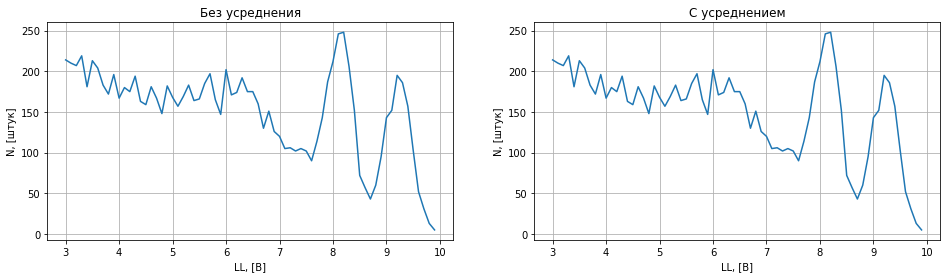

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Уберем пропуски в `N` (нули)
plot_data = df[df['N'] != 0]
# Иногда я делал два измерения. В результирующий график уйдет их среднее
axes[0].plot(plot_data['LL'], plot_data['N'])
axes[0].set_title(r'Без усреднения')
# Сравним два вида!
tmp = plot_data.loc[plot_data['NN'] != 0]
plot_data.loc[plot_data['N'] != 0]['N'] = 0.5*(tmp['N'] + tmp['NN'])
del tmp


axes[1].plot(plot_data['LL'], plot_data['N'])
axes[1].set_title(r'С усреднением')

for ax in axes:
    ax.set_xlabel(r'LL, [В]')
    ax.set_ylabel(r'N, [штук]')
    ax.grid()
# NOTE: Теперь plot_data УСРЕДНЕНА

Теперь нам надо как-то выделить пики. Попробуем несколько способов аппроксимации.

Для начала выделим **функции**, которыми будем аппроксимировать.

In [219]:
from scipy.optimize import curve_fit

# Видно, что у нас будут пологие и пиковые участки
# Для каждого из них мы определим свою функцию
# Пологие
plain_functions = [
    lambda x, a, b: a*x+b,  # Линейная
    #lambda x, a, b: a/x+b,   # Гипербола
]
# Пики
from scipy.stats import norm
peak_functions = [
    #lambda x, a, b, c: a*x**2 + b*x + c,   # Парабола
    lambda x, mu, sigma, a, c: a*norm(loc=mu, scale=sigma).pdf(x) + c
]

In [220]:
# Теперь сама аппроксимация
# Я немного захардкодю точки перемены монотонности. Не бейте за это!
x_1, x_2, x_3 = 7.5, 8.8, 10
plain_data = plot_data.loc[plot_data['LL'] < x_1]
peak1_data = plot_data.loc[(x_1 <= plot_data['LL']) & (plot_data['LL'] < x_2)]
peak2_data = plot_data.loc[(x_2 < plot_data['LL']) & (plot_data['LL'] < x_3)]

Мы будем отбирать из функций те, что дадут меньшую погрешность!

In [222]:
# For plain area
def find_optimal_function(data, functions):
    opt_func = functions[0]
    opt_param = []
    prev_err = np.inf
    for func in functions:
        popt, pcov = curve_fit(func, data['LL'], data['N'])
        perr = np.sqrt(np.diag(pcov))[0]
        if perr < prev_err:
            opt_func = func
            opt_param = popt
    print(opt_param)
    return lambda x: opt_func(x, *opt_param)

plain_opt_func = find_optimal_function(plain_data, plain_functions)
# НЕ РАБОТАЕТ
#peak1_opt_func = find_optimal_function(peak1_data, peak_functions)
#peak2_opt_func = find_optimal_function(peak2_data, peak_functions)

[-17.26218705 258.87448376]


In [246]:
peak1_opt_func = lambda x, a, b: a*norm(loc=8.15, scale=0.3).pdf(x) + b
peak2_opt_func = lambda x, a, b: a*norm(loc=9.25, scale=0.3).pdf(x) + b

def optimize_norm_function(norm_function, x_data, y_data):
    popt, pcov = curve_fit(norm_function, x_data, y_data)
    return lambda x: norm_function(x, *popt)

peak1_opt_func = optimize_norm_function(peak1_opt_func, peak1_data['LL'], peak1_data['N'])
peak2_opt_func = optimize_norm_function(peak2_opt_func, peak2_data['LL'], peak2_data['N'])

Нарисуем оптимальные функции

/home/aleksei/.virtualenvs/ml/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


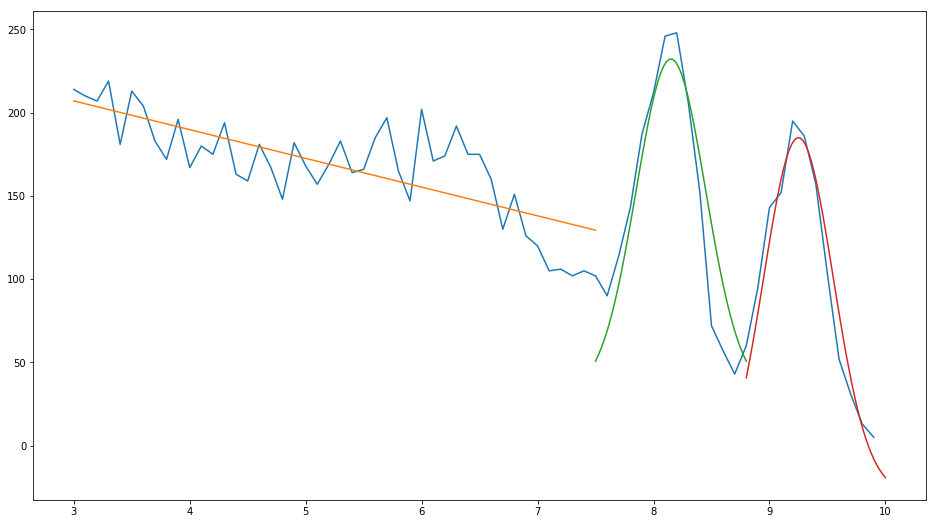

In [247]:
fig, ax = plt.subplots(figsize=(16, 9))

plain_range = np.linspace(plot_data['LL'].min(), x_1)
peak1_range = np.linspace(x_1, x_2)
peak2_range = np.linspace(x_2, x_3)

ax.plot(plot_data['LL'], plot_data['N'])
ax.plot(plain_range, plain_opt_func(plain_range))
# Сделаем еще интерполяцию сплайнами
from scipy.interpolate import interp1d, spline
# Интерполяция
#ax.plot(np.linspace(3, 9.9, 1000), interp1d(plot_data['LL'], plot_data['N'], kind='cubic')(np.linspace(3, 9.9, 1000)))
# Сплайны
#ax.plot(np.linspace(3, 9.9, 1000), spline(plot_data['LL'], plot_data['N'], np.linspace(3, 9.9, 1000), order=5))
ax.plot(peak1_range, peak1_opt_func(peak1_range))
ax.plot(peak2_range, peak2_opt_func(peak2_range))

fig.show()

Выглядит _ОЧЕНЬ_ страшно. Но ничего! Отсюда мы имеем максимумы!

$$\boxed{a_1 = 8.15 \text{, [B]}\\
a_2 = 9.25 \text{, [B]}}$$

Отсюда мы имеем ДЕРЬМО!